<a href="https://colab.research.google.com/github/fdedo/MLProject_DeDomenico/blob/main/Notebook_sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**
The aim of this project is to build a model that analyzes financial news headlines and determines whether the sentiment is positive, negative or neutral from the perspective of a retail investor.
\
**Sentiment analysis**, also known as opinion mining, encompasses a range of techniques designed to detect the underlying sentiment of texts, such as product reviews, social media posts or news articles. It falls under the umbrella of natural language processing (NLP).\
In recent years, significant efforts have been directed towards developing tools for gauging collective sentiment for various purposes, spanning from political analyses to business considerations. For instance, discerning the reaction to critical financial news enables better prediction of future population behavior and facilitates informed decision-making.
\
Additionally, companies employ sentiment analysis to gather extensive feedbacks on their products, with the intention of making improvements.
In our interconnected world, the significance of how news is perceived has emerged as a crucial issue, as evidenced by recent events like the economic crisis and the Covid pandemic.

\
**Project outline**

**1.Data cleaning and preprocessing**:
Cleaning and preprocessing the text data is a crucial first step.
\
**2.Text-to-Numerical Conversion**:
Converting text into numerical features is necessary for machine learning algorithms. This step involves techniques like tokenization and then mapping these tokens to numerical values, with embeddings. Data are labelled with sentiment categories (negative, neutral, positive).
\
**3. Machine Learning Models**: Using Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) for sentiment analysis is a common approach.
\
**4.Model Training and Evaluation**: Data are split into training and test. For model selection we use K-Fold Cross Validation because dataset is not particularly large. The performance is evaluated using accuracy and confusion matrices on the test set.
\
**5.Comparison**: CNN and RNN are compared.
\
**6. Conclusions and outlook**

\
\
**Useful references**

[1] Malo, P., Sinha, A., Korhonen, P., Wallenius, J., & Takala, P. (2014),*Good debt or bad debt: Detecting semantic orientations in economic texts*, Journal of the Association for Information Science and Technology, 65(4), 782-796.

[2]Chakraborty K, Bhattacharyya S, Bag R., *A Survey of Sentiment Analysis from Social Media Data*, IEEE Transactions on Computational Social Systems. 2020;7(2):450–464.

[3] Aletti G, Crimaldi I, Saracco F (2021), *A model for the Twitter sentiment curve*, PLOS ONE 16(4): e0249634. https://doi.org/10.1371/journal.pone.0249634


#**Setting up the input pipeline**


**Kaggle API** \
As a first step, Kaggle API is used to download the dataset. Moreover, the working directory is mounted on the Drive where all actions are implemented.

In [ ]:
from google.colab import files
! pip install -q kaggle
files.upload() # Uploading kaggle API token for identification
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive #Mounting the drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MLProject_DeDomenico/

Mounted at /content/drive
/content/drive/MyDrive/MLProject_DeDomenico


In [ ]:
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news #Downloading the dataset
!unzip sentiment-analysis-for-financial-news.zip #Unzipping

sentiment-analysis-for-financial-news.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment-analysis-for-financial-news.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


As a second step, the main libraries that will be called throughout the project are imported. Further modules will be imported when needed.\
Note that the seed for random number generation is set for reproducibility.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import*

seed = 123 #Seeding for reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)


##**Dataset**
The chosen dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor and can be downloaded from Kaggle at this [link](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news?resource=download). Note that different versions of dataset can be used; we have chosen the version in which 16 annotators are involved and a specific label is assigned if, at least, half of the annotators agrees on the identification. Since the minimum threshold is 50% of annotators, it is possible that some data are hard to recognise even for "humans"; this could impact the performace of the model.


In [ ]:
filename = 'FinancialPhraseBank/Sentences_50Agree.txt' #All data are stored into a single text file with format "text_entry @label\n"
data = []
with open(filename, 'r',encoding = "ISO-8859-1") as f:
  for line in f:
    line = line.strip() #Removing newline character
    data.append(line.split('@')) #Splitting each line into [text_entry,label] list

cols = ['text_entry','label'] #Creating a dataframe to store the data samples
df = pd.DataFrame(data,columns=cols)
df

,text_entry,label
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,negative
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4843,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4844,Net sales of the Paper segment decreased to EU...,negative


Class distribution is now checked: as it can be seen, neutral label is more frequent than the other two labels. Thus we can say that we are working with unbalanced data, a feature that will affect models.  

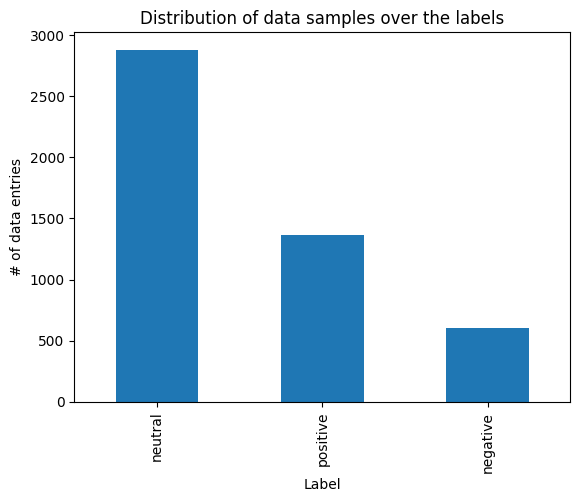

In [ ]:
fig, ax = plt.subplots()
df['label'].value_counts().plot(ax=ax, kind='bar')
plt.title('Distribution of data samples over the labels')
plt.xlabel('Label')
plt.ylabel('# of data entries')
plt.show()

To give an idea of some news headline, we print an example for each label.

In [ ]:
print('Example of neutral class:\n')
print(df.iloc[0].text_entry)
print('\nExample of positive class:\n')
print(df.iloc[3].text_entry)
print('\nExample of negative class:\n')
print(df.iloc[2].text_entry)


Example of neutral class:

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .

Example of positive class:

With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .

Example of negative class:

The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .


##**Text cleaning**
The text needs to be cleaned, namely any unnecessary characters (such as stopwords) or symbols must be removed and the text is converted to lowercase. Then, each label is associated to an integer number: 0 for neutral, +1 for positive and -1 for negative sentiments.

In [ ]:
import re     # For regular expression support
import nltk   # For standard text-processing tasks
nltk.download('stopwords') #Downloading an english stopwords corpus (needed to exclude common words like prepositions and articles)
from nltk.corpus import stopwords

# Some helper functions for pre-processing the text
def remove_urls(text):
    """Removes urls and relted"""
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    """Removes html and related"""
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

def punct_remove(text):
    """Strips punctuation and related"""
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def remove_stopwords(text):
    """Removes stopwords"""
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Complete text-cleaning (remove urls, html, punctuations, stopwords, introduce lower cases)
def clean_text(text):

    new_text = remove_urls(text)

    new_text = remove_html(new_text)

    new_text = punct_remove(new_text)

    new_text = new_text.strip().lower()

    new_text = remove_stopwords(new_text)

    return new_text


def lab2number(label):
  """Converts class string label into integer number"""
  if label == 'positive':
    number = 1
  if label == 'negative':
    number = -1
  if label == 'neutral':
    number = 0
  return number

# Clean text
df['text_entry'] = df['text_entry'].apply(lambda x: clean_text(x))
# COnverts label into number
df['label'] = df['label'].apply(lambda x : lab2number(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The maximum length in the text entries is checked in order to pad all the sequences to this length.

In [ ]:
#Checking max length of our text samples
max_len = (df['text_entry'].apply(lambda x: len(x.split(' ')))).max()
#Showing processed dataframe
df

,text_entry,label
0,according gran company plans move production r...,0
1,technopolis plans develop stages area less 100...,0
2,international electronic industry company elco...,-1
3,new production plant company would increase ca...,1
4,according company updated strategy years 20092...,1
...,...,...
4841,london marketwatch share prices ended lower lo...,-1
4842,rinkuskiai beer sales fell 65 per cent 416 mil...,0
4843,operating profit fell eur 354 mn eur 688 mn 20...,-1
4844,net sales paper segment decreased eur 2216 mn ...,-1


In [ ]:
print('Maximum lenght of the text entries:', str(max_len))

Maximum lenght of the text entries: 46


##**Setting up the tokenizer**
Keras TextVectorization layer is used to standardize the text. The adapt function defines a vocabulary, used as a mapping between words and numerical indices. In this way, text data are encoded as sequences of integers.

Note that the vocabulary itself is created by storing each unique word encountered in the text corpus. However, there are around 10000 unique words, most of which appears once; hence, the vocabulary is reduced to the most frequent words (5000). Anyway, this strategy does not take into account words which have similar meanings.  

In [ ]:
#Converting all text data into a single corpus from which to extract a vocabulary
text_data = list(df.text_entry.values)
#Setting up a text vectorization layer
tokenizer = TextVectorization(output_mode="int",output_sequence_length=int(max_len),max_tokens=5000) #fix max number of tokens to 5000
#Adapting on corpus
tokenizer.adapt(text_data)
voc_size = tokenizer.vocabulary_size()

In [ ]:
#Vectorized (into integers) text entries
tokenized_text = tokenizer(text_data).numpy().tolist()
#Adding a column to df
df['tokenized_text'] = tokenized_text


##**Embedding**
Our data is too small to create reliable emebedding, hence we rely on external embedding which are more completed. In addition, this strategy reduces the complexity of our model, as the many parameters introduced by the embedding need not to be trained. Thus Glove-wiki-gigaword-100 trained on Wikipedia and Gigaword 5 Data is introduced to obtain 100-dimensional embedded vector.
Hence, the embedding matrix is built, which allows the conversion from vocabulary space to embedded space.

In [ ]:
import gensim.downloader as api
#Download the pretrained embeddings through gensim
glove_word2vec = api.load("glove-wiki-gigaword-100")


[================================================--] 96.5% 123.5/128.1MB downloaded


In [ ]:

def get_embedding(voc_size,tokenizer,glove_vec):
  embedded_matrix = np.zeros((voc_size, 100))
  #Loop on entire vocabulary
  for i, word in enumerate(tokenizer.get_vocabulary()):
      try:
        #Using the hash table structure of the glove_vec to get the embedded vector associated to each word
        embedded_vector = glove_vec[word]
        embedded_matrix[i] = embedded_vector
      except:
        pass
  return embedded_matrix

emb_matrix = get_embedding(voc_size,tokenizer,glove_word2vec)


##**Assembling the pieces**
Having all the ingredients, it is time to wrap it up: dataframe, vocabulary and embedding matrix are saved and then files are loaded to skip the preprocessing part.

In [ ]:
df_path = 'prepro_data.csv'
embed_path = 'embedding_matrix.npy'
voc_path = 'vocabulary.txt'

In [ ]:
#Saving embedding matrix
np.save(embed_path, emb_matrix)

#Saving vocabulary
voc = tokenizer.get_vocabulary()
with open(voc_path,'w') as voc_file:
  for word in voc:
    voc_file.write("%s\n" % word)

#Saving dataframe
df.to_csv(df_path)

In [ ]:
#Loading
embedding_matrix = np.load(embed_path)
df = pd.read_csv(df_path)
with open(voc_path,'r') as voc_file:
  voc = voc_file.readlines()
  voc_size = len(voc)

In [ ]:
#This is needed to convert the "tokenized_text" column entries from string(list) to list
from ast import literal_eval
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: np.array(literal_eval(x)))


###**Splitting training and test sets**
Dataset is split: 90% of data is devoted to the train part and 10% for the test.  

In [ ]:
from keras.utils.np_utils import to_categorical #To be used to encode the labels as one-hot vectors
X = np.stack(df['tokenized_text'].to_numpy()) #Data samples
Y = df['label'].to_numpy()
Y = tf.convert_to_tensor(to_categorical(Y, num_classes=3)).numpy().astype(int) #Target labels (one-hot encoding)

print(X.shape, Y.shape) #Checking the shape


(4846, 46) (4846, 3)
[1 0 0]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify= Y, test_size=0.10, random_state=seed) #Train-Test splitting
print(X_train.shape, Y_train.shape) #Stratified is used to preserve class distribution when the splitting is applied
del(X) #To save memory
del(Y)
# X and Y are left as numpy arrays for cross-validation

(4361, 46) (4361, 3)


#**First model: CNN**
Two architectures are adopted in this project. The first is a Convolutional Neural Network (CNN), which is effective for extracting local patterns from text data. The second one is a Recurrent Neural Network (RNN) which is better at capturing sequential dependencies.\
We start with CNN; we use 1D convolution as they are specific for sequences. Moreover, we interval with pooling layers and dropouts layers to reduce the dimensionality and make models more generalizable.  The final part of the architcture are fully-connected layers, the last returning a probability distribution over the classes.

In [ ]:
def get_cnn_classifier():
  classifier = keras.Sequential([
      Embedding(input_dim = voc_size, output_dim = 100, embeddings_initializer = keras.initializers.Constant(embedding_matrix),trainable=False, name='Embedding'),
      Dropout(0.25, name = 'Dropout_1'), #For generalization
      Conv1D(32, 3, activation='relu', padding='same', strides=1, name = 'Conv1D_1'),
      Conv1D(32, 3, activation='relu', padding='same', strides=1,name = 'Conv1D_2'),
      MaxPool1D(name = 'MaxPooling_1'),
      Dropout(0.25,name = 'Dropout_2'), #For generalization
      Conv1D(64, 3, activation='relu', padding='same', strides=1,name = 'Conv1D_3'),
      Conv1D(64, 3, activation='relu', padding='same', strides=1,name = 'Conv1D_4'),
      MaxPool1D(name = 'MaxPooling_2'),
      Dropout(0.25, name = 'Dropout_3'), #For generalization
      Conv1D(128, 3, activation='relu', padding='same', strides=1,name = 'Conv1D_5'),
      Conv1D(128, 3, activation='relu', padding='same', strides=1,name = 'Conv1D_6'),
      GlobalMaxPool1D(name = 'editGlobalMaxPooling'),
      Dropout(0.25,name = 'Dropout_4'), #For generalization
      Dense(128, activation = 'relu',name = 'FullyConnected_1'),
      Dropout(0.25,name = 'Dropout_5'), #For generalization
      Dense(3, activation = 'softmax',name = 'Classification')
  ], name = 'CNN_Classifier' )
  return classifier

example = get_cnn_classifier()
example.summary() #Summary

Model: "CNN_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 Dropout_1 (Dropout)         (None, None, 100)         0         
                                                                 
 Conv1D_1 (Conv1D)           (None, None, 32)          9632      
                                                                 
 Conv1D_2 (Conv1D)           (None, None, 32)          3104      
                                                                 
 MaxPooling_1 (MaxPooling1D)  (None, None, 32)         0         
                                                                 
 Dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 Conv1D_3 (Conv1D)           (None, None, 64)       

##**Training**


###**K-Fold Cross Validation**
To evaluate the model's performance, the K-Fold Cross Validation is adopted, a technique particularly suited for our limited dataset.\
As for the training process, the Adaptive Moment Estimation (Adam) optimization scheme is adopted with standard hyperparameters.\
After multiple attempts, we observed that a batch size of 128 and 50 epochs provide the most optimal results. For instance, we experimented with 80 epochs, but found that it hindered the model's generalizability due to excessive training.

In [ ]:
#Training hyperparameters
batch_size = 128
epochs = 50

End of fold 0:
 final training accuracy: 0.8042114973068237
 final validation accuracy: 0.6129032373428345 


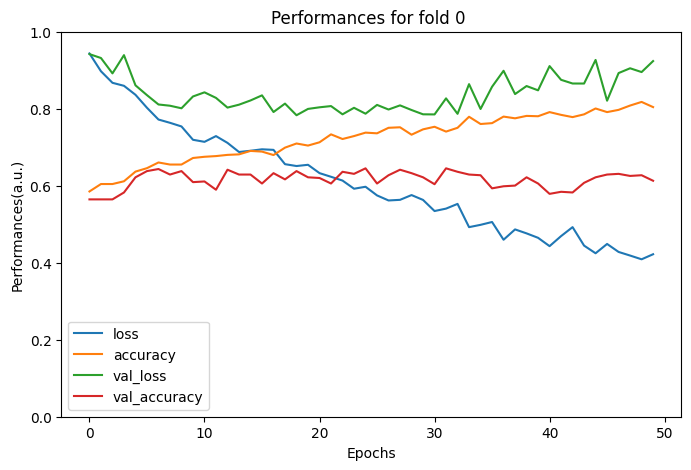

End of fold 1:
 final training accuracy: 0.8418458700180054
 final validation accuracy: 0.7150537371635437 


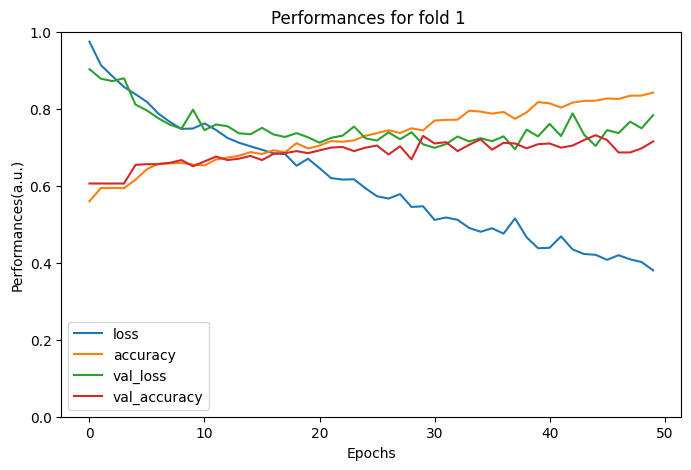

End of fold 2:
 final training accuracy: 0.8400537371635437
 final validation accuracy: 0.7311828136444092 


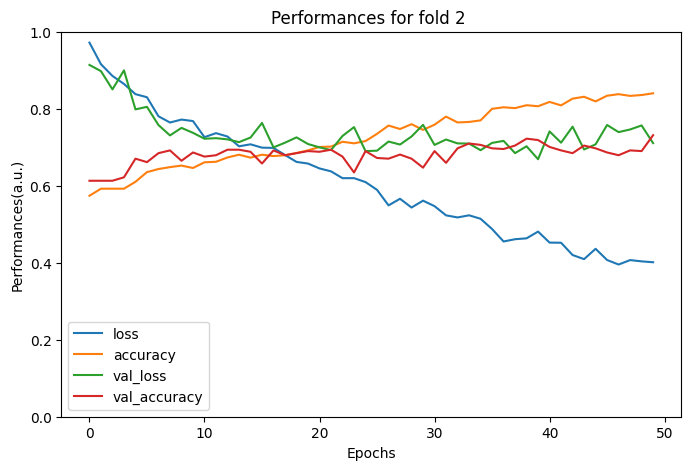

End of fold 3:
 final training accuracy: 0.8494623899459839
 final validation accuracy: 0.6935483813285828 


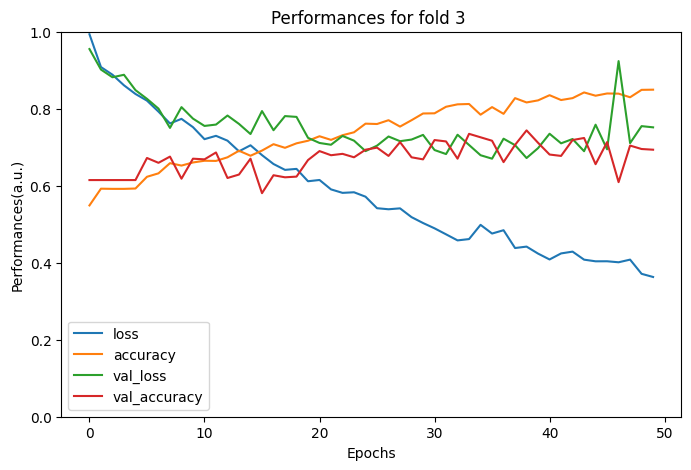

End of fold 4:
 final training accuracy: 0.8584229350090027
 final validation accuracy: 0.6738350987434387 


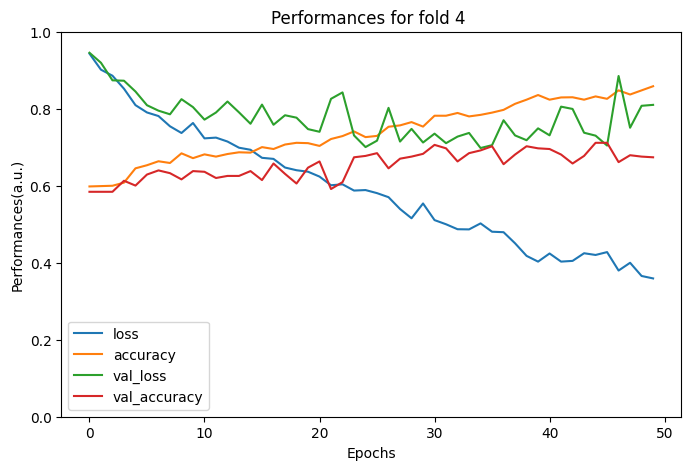

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5) #5 folds

train_acc = [] #Stored to see the avarage result of the K-fold cross validation
val_acc = []

# Loop over the dataset to create separate folds
X = np.copy(X_train) #Needed not to mess with the data
Y = np.copy(Y_train)

for i, indices in enumerate(kf.split(X)):

  train_index = indices [0]
  val_index = indices [1]
  #Splitting into train and val
  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = Y[train_index], Y[val_index]
  # Create a new model instance
  model = get_cnn_classifier()
  model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # train the model on the current fold
  history=model.fit(X_train, Y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=0)
  EOT_acc = np.array(history.history['accuracy'])[-1] #Accuraccy at End Of Training
  EOT_val_acc = np.array(history.history['val_accuracy'])[-1] #Validation accuracy at the End Of Training

  print('End of fold {0}:\n final training accuracy: {1}\n final validation accuracy: {2} '.format(i, EOT_acc, EOT_val_acc))
  train_acc.append(EOT_acc)
  val_acc.append(EOT_val_acc)
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
  plt.title('Performances for fold {0} '.format(i))
  plt.xlabel('Epochs')
  plt.ylabel('Performances(a.u.)')
  plt.show()

After the 5-Fold Cross Validation process, we estimate that, at the end of a 50-epoch training, our network will perform as follows.

In [ ]:
#Averaging
mean_acc = np.array(train_acc).mean()
mean_val_acc = np.array(val_acc).mean()

print('Average training accuracy: {0}\nAverage validation accuracy: {1}'.format(mean_acc,mean_val_acc))

Average training accuracy: 0.8400028586387634
Average validation accuracy: 0.7110837817192077


###**Training the complete model**
Looking at the losses, the model seems to be still training, but the other metrics have clearly reached saturation. As said, 50 seems a reasonable number for epochs in this case. Hence, we now use the whole training dataset. The final accuracy is approximately 0.83, in pretty good agreement with the average equal to 0.84.

In [ ]:
#Instancing a new model
cnn = get_cnn_classifier()
#Model checkpointer (saves trained weights)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='SavedModels/cnn.weights.best.hdf5', verbose = 1)
cnn.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#Training history
history = cnn.fit(X, Y,batch_size=batch_size, epochs=epochs, verbose=1,callbacks =[checkpointer])
print('Final training accuracy: {0}'.format(np.array(history.history['accuracy'])[-1]))


Epoch 1/50
27/28 [===========================>..] - ETA: 0s - loss: 0.9361 - accuracy: 0.5885
Epoch 1: saving model to SavedModels/cnn.weights.best.hdf5
28/28 [==============================] - 6s 152ms/step - loss: 0.9370 - accuracy: 0.5881
Epoch 2/50
27/28 [===========================>..] - ETA: 0s - loss: 0.8811 - accuracy: 0.5972
Epoch 2: saving model to SavedModels/cnn.weights.best.hdf5
28/28 [==============================] - 2s 86ms/step - loss: 0.8815 - accuracy: 0.5962
Epoch 3/50
27/28 [===========================>..] - ETA: 0s - loss: 0.8416 - accuracy: 0.6082
Epoch 3: saving model to SavedModels/cnn.weights.best.hdf5
28/28 [==============================] - 2s 84ms/step - loss: 0.8412 - accuracy: 0.6088
Epoch 4/50
27/28 [===========================>..] - ETA: 0s - loss: 0.8142 - accuracy: 0.6380
Epoch 4: saving model to SavedModels/cnn.weights.best.hdf5
28/28 [==============================] - 2s 83ms/step - loss: 0.8145 - accuracy: 0.6383
Epoch 5/50
27/28 [=================

#**Second model: RNN**
As second model, the Recurrent Neural Network is adopted. In particular, the Long Short-Term Memory (LSTM) architecture has been chosen. We use two bidirectional layers that process input backward and forward. We have dropouts layers here as well, for generalisation. The final part of the architcture are fully-connected layers, the last returning a probability distribution over the classes. Implementation steps are the same as before, yet this time we train for 35 epochs.

In [ ]:
def get_rnn_classifier():
  classifier = tf.keras.Sequential([
      Embedding(input_dim = voc_size, output_dim = 100, embeddings_initializer = keras.initializers.Constant(embedding_matrix),trainable=False, name='Embedding'),
      Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True), name = 'LSTM_1'),
      Bidirectional(LSTM(64), name = 'LSTM_2'),
      Dropout(0.25, name = 'Dropout_1' ),
      Dense(128, activation = 'relu', name = 'FullyConnected_1'),
      Dropout(0.25,name = 'Dropout_2'),
      Dense(64, activation = 'relu', name = 'FullyConnected_2'),
      Dropout(0.25, name = 'Dropout_3'),
      Dense(3, activation = 'softmax', name = 'Classification')
      ], name = 'RNN_Classifier')
  return classifier

example = get_rnn_classifier()
example.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, None, 100)         500000    
                                                                 
 LSTM_1 (Bidirectional)      (None, None, 256)         234496    
                                                                 
 LSTM_2 (Bidirectional)      (None, 128)               164352    
                                                                 
 Dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 FullyConnected_1 (Dense)    (None, 128)               16512     
                                                                 
 Dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 FullyConnected_2 (Dense)    (None, 64)                8

End of fold 0:
 final training accuracy: 0.9885345697402954
 final validation accuracy: 0.719197690486908 


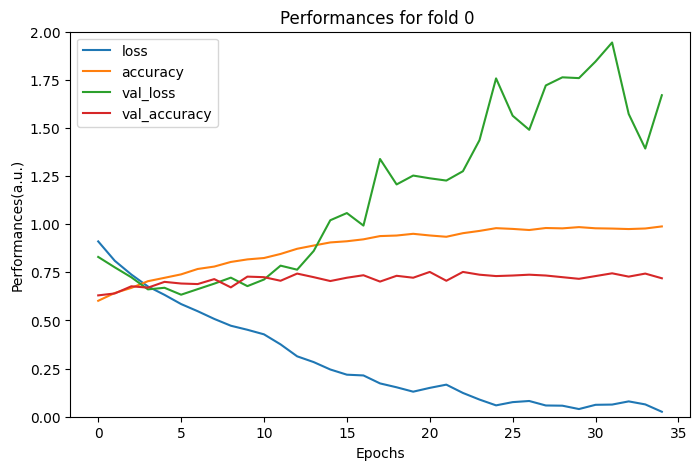

End of fold 1:
 final training accuracy: 0.9867430925369263
 final validation accuracy: 0.7449856996536255 


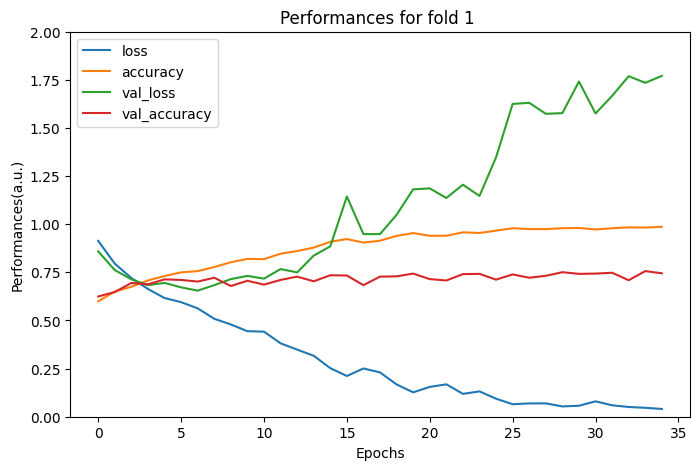

End of fold 2:
 final training accuracy: 0.9842350482940674
 final validation accuracy: 0.7220630645751953 


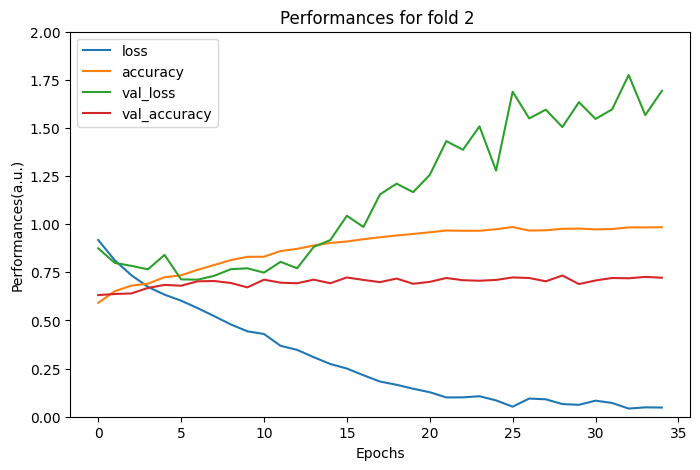

End of fold 3:
 final training accuracy: 0.9770691394805908
 final validation accuracy: 0.7521489858627319 


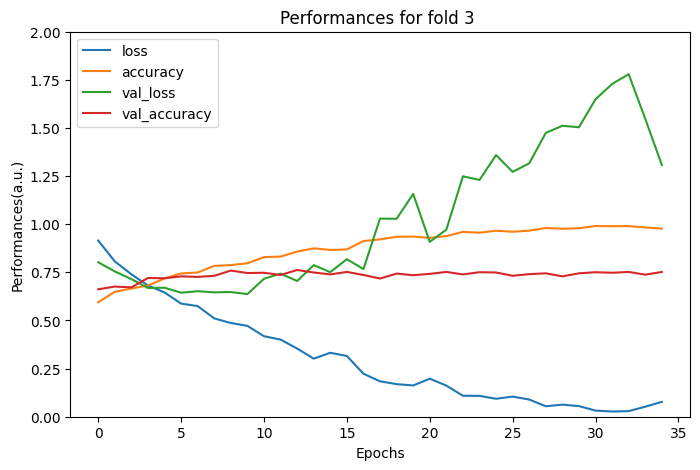

End of fold 4:
 final training accuracy: 0.985315203666687
 final validation accuracy: 0.7044476270675659 


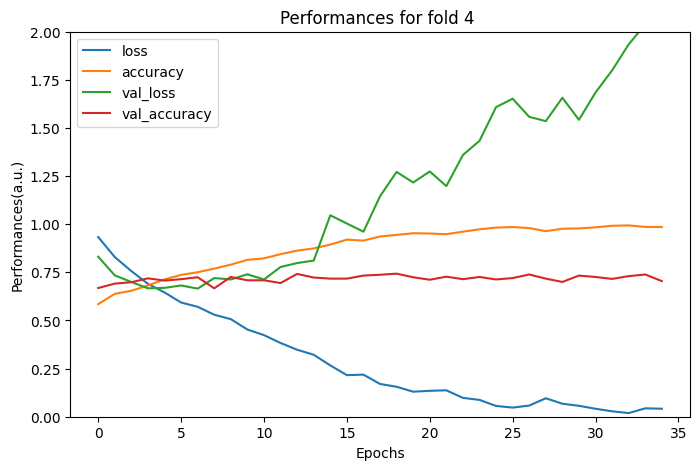

In [ ]:
epochs = 35

train_acc = []
val_acc = []

# Loop over the dataset to create seprate folds
for i, indices in enumerate(kf.split(X)):

  train_index = indices [0]
  val_index = indices [1]

  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = Y[train_index], Y[val_index]
  # Create a new model instance
  model = get_rnn_classifier()
  model.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

  # train the model on the current fold
  history=model.fit(X_train, Y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=0)
  EOT_acc = np.array(history.history['accuracy'])[-1]
  EOT_val_acc = np.array(history.history['val_accuracy'])[-1]

  print('End of fold {0}:\n final training accuracy: {1}\n final validation accuracy: {2} '.format(i, EOT_acc, EOT_val_acc))
  train_acc.append(EOT_acc)
  val_acc.append(EOT_val_acc)
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.gca().set_ylim(0, 2) # set the vertical range to [0-2] to see the full trends
  plt.title('Performances for fold {0} '.format(i))
  plt.xlabel('Epochs')
  plt.ylabel('Performances(a.u.)')
  plt.show()

In [ ]:
mean_acc = np.array(train_acc).mean()
mean_val_acc = np.array(val_acc).mean()

print('Average training accuracy: {0}\nAverage validation accuracy: {1}'.format(mean_acc,mean_val_acc))

Average training accuracy: 0.9843794107437134
Average validation accuracy: 0.7285686135292053


##**Training the complete model**
The final model is evaluated for just 10 epochs, because it overfits with an higher number. The reason for the overfitting (even 20%) is due to the increase in model complexity (in fact, it has four times the number of parameters of CNN!).
At the end of 10 epochs, we register an accuracy of 0.83.

In [ ]:
rnn = get_rnn_classifier()
epochs = 10
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='SavedModels/rnn.weights.best.hdf5', verbose = 1)
rnn.compile( optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = rnn.fit(X, Y,batch_size=batch_size, epochs=epochs, verbose=1,callbacks =[checkpointer])
print('Final training accuracy: {0}'.format(np.array(history.history['accuracy'])[-1]))

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.9391 - accuracy: 0.5810
Epoch 1: saving model to SavedModels/rnn.weights.best.hdf5
22/22 [==============================] - 23s 622ms/step - loss: 0.9391 - accuracy: 0.5810
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.6584
Epoch 2: saving model to SavedModels/rnn.weights.best.hdf5
22/22 [==============================] - 15s 669ms/step - loss: 0.8071 - accuracy: 0.6584
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.7749 - accuracy: 0.6581
Epoch 3: saving model to SavedModels/rnn.weights.best.hdf5
22/22 [==============================] - 19s 840ms/step - loss: 0.7749 - accuracy: 0.6581
Epoch 4/10
22/22 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.6871
Epoch 4: saving model to SavedModels/rnn.weights.best.hdf5
22/22 [==============================] - 19s 871ms/step - loss: 0.7087 - accuracy: 0.6871
Epoch 5/10
22/22 [==========

#**Comparison of the two models**
Finally, the two models are compared. First we compare the accuracies on test set and, then, the relative confusion matrices. As it can be seen from the table, with a similar train accuracy, the RNN reaches a higher test accuracy, as said with a larger number of parameters. Note that the training of the RNN is more computational expensive.

In [ ]:
#Loading CNN trained weights
trained_cnn = get_cnn_classifier()
trained_cnn.load_weights('SavedModels/cnn.weights.best.hdf5')
trained_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) #Model must be compiled for evaluation mode

In [ ]:
#Loading RNN trained weights
trained_rnn = get_rnn_classifier()
trained_rnn.load_weights('SavedModels/rnn.weights.best.hdf5')
trained_rnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) #Model must be compiled for evaluation mode

##**Evaluation on test set**


In [ ]:
print('Performance of the CNN classifier on test set:\n')
trained_cnn.evaluate(X_test,Y_test)
print('\n')
print('Performance of the RNN classifier on test set:\n')
trained_rnn.evaluate(X_test, Y_test)

Performance of the CNN classifier on test set:

16/16 [==============================] - 1s 7ms/step - loss: 0.6981 - accuracy: 0.6619


Performance of the RNN classifier on test set:

16/16 [==============================] - 4s 76ms/step - loss: 0.6255 - accuracy: 0.7608


[0.6255335211753845, 0.7608247399330139]

Summing up the results:

|Model |Train Accuracy | Test Accuracy |Number of parameters|
|------|---------------|---------------|-------------------|
|CNN  |82.5%|66.2% | 122,179|
|RNN  |82.3% |76.1% | 423,811|



##**Confusion matrices**
As final test, confusion matrices of the two models are compared. \
As it can be seen, both models better recognise the neutral group, as this class is the most populated one and this leads to a bias for both architectures.

Overall, RNN is better than CNN in recognising the negative and positive classes. This can be due to how models are built: CNN just takes implicit patterns in the structure, while RNN takes into account the sequential pattern, with more parameters, and gives more accurate results. It can be seen that CNN declassify positive data more than 50% of the time, while RNN correclty classifies elements at least for half of the total times. Note also that off-diagonals terms generally are bigger for (1,2) and (1,3) in CNN while RNN seems to change positive in negatives.

In [ ]:
Y_cnn = trained_cnn.predict(X_test) #CNN predicted probs
Y_cnn = np.argmax(Y_cnn, axis=1) #Predicted label as most probable
Y_rnn = trained_rnn.predict (X_test) #RNN predicted probs
Y_rnn = np.argmax(Y_rnn, axis=1)
Y_real = np.argmax(Y_test,axis=1) #From one-hot encoding to single 'integer' class

16/16 [==============================] - 3s 160ms/step


In [ ]:
#Importing function for confusion matrix
from sklearn.metrics import confusion_matrix
cnn_cm = confusion_matrix(Y_real, Y_cnn,normalize = 'pred') #Both confusion matrices are normalized
rnn_cm = confusion_matrix(Y_real, Y_rnn, normalize = 'pred')


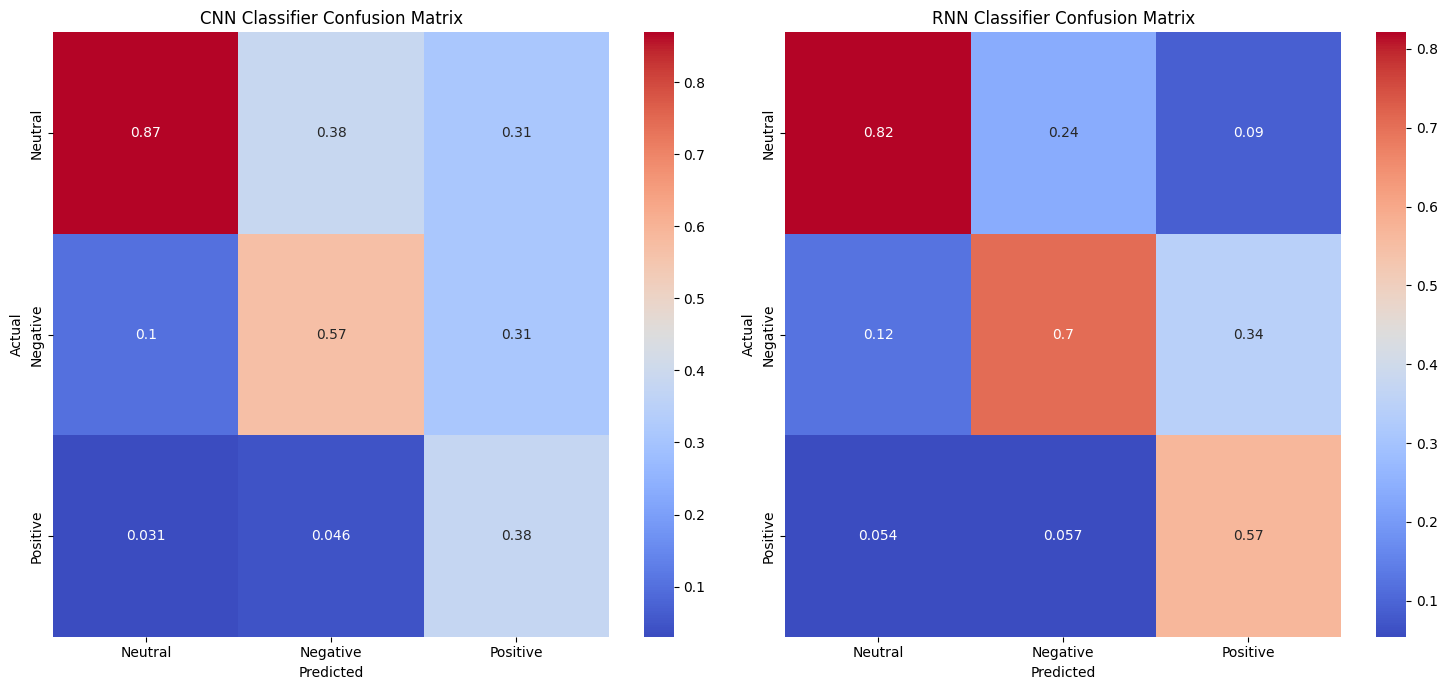

In [ ]:
#Importing seaborn for easy plotting
import seaborn as sn
plot_cnn = pd.DataFrame(cnn_cm, index = [i for i in ['Neutral','Negative','Positive']],
                  columns = [i for i in ['Neutral','Negative','Positive']])

plot_rnn = pd.DataFrame(rnn_cm, index = [i for i in ['Neutral','Negative','Positive']],
                  columns = [i for i in ['Neutral','Negative','Positive']])


fig, axes = plt.subplots(1, 2, figsize=(15, 7)) #Plot side by side

# Plotting CNN confusion matrix
sn.heatmap(plot_cnn, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('CNN Classifier Confusion Matrix')

# Plotting RNN confusion matrix
sn.heatmap(plot_rnn, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('RNN Classifier Confusion Matrix')

# Adjust layout
plt.tight_layout()
plt.show()

#**Summary and conclusions**
As pointed out, with this dataset and implementation, the RNN model requires an higher number of parameters than the CNN (approximately four times), yet it can be trained with just ten epochs with better results. Overall, RNN is better than CNN in recognising the negative and positive classes.

As it can be observed, the neutral label has better results because it has more elements. Therefore a natural improvement would be the adoption of a more balanced dataset.

Another implementation could involve understanding which words have heavier weights and the different behaviour of CNN and RNN.

It could also be interesting to check whether specific words proper of financial vocabulary (such as MLN for million) are present in headlines and include them in analysis, perhaps with an embedding specific to our problem.

Moreover, larger dataset could be adopted and attention mechanisms could be implemented to further improve the analysis.